In [1]:
# Stanisław Wilczyński project1
import sys
from time import time

import numpy as np

%pylab inline
from __future__ import print_function
STEPS = 2 * 10**3
INDEPENDENT = 'independent'
SAME_CORR = 'same_corr'
AUTO_CORR = 'auto_corr'
GD = 'gd'
SGD = 'sgd'
SAGA = 'saga'
SVRG = 'svrg'

Populating the interactive namespace from numpy and matplotlib


Below are implemented GD, SGD, SAGA and SVRG as well as data generation for our logistic regression model

In [2]:
def loss(a, x, y):
    xb = np.dot(x, a)
    return np.sum(np.log(1 + np.exp(xb)) - np.multiply(y, xb))


def generate_data(n, d, ro, option, debug=False):
    mean = np.zeros(d)
    if option == INDEPENDENT:
        cov = np.identity(d)
        if debug:
            print('Mean and covariance {} \n {}'.format(mean, cov))
        return np.random.multivariate_normal(mean, cov, n)
    if option == SAME_CORR:
        cov = np.ones((d, d)) * ro + np.identity(d) * (1 - ro)
        if debug:
            print('Mean and covariance {} \n {}'.format(mean, cov))
        return np.random.multivariate_normal(mean, cov, n)
    if option == AUTO_CORR:
        cov = [[ro ** np.abs(i - j) for i in range(d)] for j in range(d)]
        if debug:
            print('Mean and covariance {} \n {}'.format(mean, cov))
        return np.random.multivariate_normal(mean, cov, n)

    raise Exception('Wrong option')


def generate_response(X, beta, debug=False):
    p = np.exp(np.dot(X, beta)) / (1 + np.exp(np.dot(X, beta)))
    if debug:
        print('Probability\n', p)
    return np.random.binomial(1, p).reshape(-1, 1)


def generate_all(n,d,ro, data_generation, is_prox=False):
    beta = np.random.uniform(-1, 2, d).reshape(-1, 1)  # very important reshape
    if is_prox:
        ind = np.random.permutation(np.arange(d))[:-d//8]
        beta[ind] = 0
    x = generate_data(n, d, ro, data_generation)
    y = generate_response(x, beta)
    return x,y,beta
    

# proximal for lambda penalty - as in the lecture
def proximal(a, step, lam):
    d = a.shape[0]
    return np.multiply(np.sign(a), np.maximum((np.abs(a) - lam * step), np.zeros((d, 1))))


# gradient step for logistic regression model - as in project
def grad_step(a, x, y, step=0.01):
    n = x.shape[0]
    p = np.exp(np.dot(x, a)) / (1 + np.exp(np.dot(x, a))).reshape(n, 1)
    grad_a = np.dot(x.T, (p - y))
    return a - step * grad_a


# stochastic gradient step - calculate gradient with respect only to loss connected with randomly chosen x_j
def stochastic_grad_step(a, x, y, step=0.01):
    n = x.shape[0]
    j = np.random.randint(n)
    p = np.exp(np.dot(x[j, :], a)) / (1 + np.exp(np.dot(x[j, :], a))).ravel()[0]
    grad_a = (p - y[j]) * x[j, :]
    return a - step * grad_a.reshape(-1, 1)


# gradient descent algorithm
def gradient_descent(x, y, epsilon=0.0000001, step=0.01, lam=0.01, prox=False, stochastic=False):
    n = x.shape[0]
    d = x.shape[1]
    prev_beta = np.random.randn(d).reshape(d, 1)
    a = np.random.randn(d).reshape(d, 1)
    losses = []
    steps = 0
    diff = 1000
    while ( diff > epsilon and steps < STEPS): #or steps < STEPS // 10:
        losses += [loss(a, x, y)]
        prev_beta = np.array(a)
        if stochastic:
            a = stochastic_grad_step(a, x, y, step)
        else:
            a = grad_step(a, x, y, step)
        if prox:
            a = proximal(a, step, lam)
        steps += 1
        diff = np.mean(np.abs(a - prev_beta))
        #print('GD ', diff)
    return a, losses, steps


# saga algorithm
def saga(x, y, epsilon=0.0000001, step=0.01, lam=0.01, prox=False):
    n = x.shape[0]
    d = x.shape[1]
    a = np.random.randn(d).reshape(d, 1)
    p = np.exp(np.dot(x, a)) / (1 + np.exp(np.dot(x, a))).reshape(n, 1)
    M = np.multiply(p - y, x)
    avg = np.mean(M, axis=0)
    losses = []
    prev_beta = np.random.randn(d).reshape(d, 1)
    steps = 0
    diff = 1000
    while ( diff > epsilon and steps < STEPS): #or steps < STEPS // 10:
        losses += [loss(a, x, y)]
        prev_beta = np.array(a)
        ####saga step
        j = np.random.randint(n)
        old_deriv = np.array(M[j, :])  # very important copy
        p = np.exp(np.dot(x[j, :], a)) / (1 + np.exp(np.dot(x[j, :], a))).ravel()[0]
        new_deriv = (p - y[j]) * x[j, :]
        M[j, :] = new_deriv
        a -= step * ((new_deriv - old_deriv + avg).reshape(-1, 1))
        avg += (new_deriv - old_deriv) / n
        if prox:
            a = proximal(a, step, lam)
        ####
        steps += 1
        diff = np.mean(np.abs(a - prev_beta))
        #print('SAGA ', diff)
    return a, losses, steps


# svrg algorithm
def svrg(x, y, epsilon=0.0000001, step=0.01, lam=0.01, prox=False, T=100):
    n = x.shape[0]
    d = x.shape[1]
    a = np.random.randn(d).reshape(d, 1)
    losses = []
    steps = 0
    prev_beta = np.random.randn(d).reshape(d, 1)
    diff = 1000
    # svrg outer loop
    while ( diff > epsilon and steps < STEPS): #or steps < STEPS // 10:
        a_avg = np.array(a)
        p = np.exp(np.dot(x, a_avg)) / (1 + np.exp(np.dot(x, a_avg))).reshape(n, 1)
        grad_avg = np.mean(np.multiply(p - y, x), axis=0)
        prev_beta=np.array(a)
        # svrg inner loop
        for _ in range(T):
            losses += [loss(a, x, y)]
            steps += 1
            j = np.random.randint(n)
            p = np.exp(np.dot(x[j, :], a)) / (1 + np.exp(np.dot(x[j, :], a))).ravel()[0]
            p_avg = np.exp(np.dot(x[j, :], a_avg)) / (1 + np.exp(np.dot(x[j, :], a_avg))).ravel()[0]
            deriv = (p - y[j]) * x[j, :]
            deriv_avg = (p_avg - y[j]) * x[j, :]
            a -= step * ((deriv - deriv_avg + grad_avg).reshape(-1, 1))
            if prox:
                a = proximal(a, step, lam)
        diff = np.mean(np.sum(a - prev_beta))
        #print('SVRG ', diff)
    return a, losses, steps


Function below compares our 4 methods for given data size and given learning rates for each method

In [3]:
def perform_simulation(n, d, eps, data_generation, step_sizes, lambdas, is_prox=False, start_ind=1):
    print('The data dimensions are n = {} and d = {} and precision = {}'.format(n, d, eps))
    if is_prox:
        print('87.5% of betas are set to zero')
    x,y,beta = generate_all(n,d,0.9, data_generation, is_prox=is_prox)
    if len(lambdas) == 0:
        lambdas = [0,0,0,0]
    print('---------------------------------------------------------------')
    perform_simulation_with_data(eps, data_generation, step_sizes, lambdas, x, y, beta, is_prox=is_prox, start_ind=start_ind)

def perform_simulation_with_data(eps, data_generation, step_sizes, lambdas, x, y, beta, is_prox=False, start_ind=1, show_beta=False):
    np.set_printoptions(precision=4)
    t1 = time()
    a, losses, steps_count = gradient_descent(x, y, epsilon=eps, step=step_sizes[0], lam=lambdas[0], prox=is_prox)
    t2 = time()
    print('Gradient descent took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    if show_beta:
        print('Original beta: {}\n Found beta: {}'.format(beta.ravel(), a.ravel()))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for GD: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for GD')
    print('---------------------------------------------------------------')

    t1 = time()
    a, losses, steps_count = gradient_descent(x, y, epsilon=eps, stochastic=True, step=step_sizes[1], lam=lambdas[1], prox=is_prox)
    t2 = time()
    print('Stochastic gradient descent took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    if show_beta:
        print('Original beta: {}\n Found beta: {}'.format(beta.ravel(), a.ravel()))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for SGD: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for SGD')
    print('---------------------------------------------------------------')

    t1 = time()
    a, losses, steps_count = saga(x, y, epsilon=eps, step=step_sizes[2], lam=lambdas[2], prox=is_prox)
    t2 = time()
    print('SAGA took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    if show_beta:
        print('Original beta: {}\n Found beta: {}'.format(beta.ravel(), a.ravel()))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for SAGA: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for SAGA')
    print('---------------------------------------------------------------')

    t1 = time()
    a, losses, steps_count = svrg(x, y, epsilon=eps, step=step_sizes[3], lam=lambdas[3], prox=is_prox)
    t2 = time()
    print('SVRG took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    if show_beta:
        print('Original beta: {}\n Found beta: {}'.format(beta.ravel(), a.ravel()))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for SVRG: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for SVRG')
    plt.title('Data generation method: {}'.format(data_generation))

    plt.legend()
    plt.show()

Function below allows us to find best learning rates and lambdas constants for given function and data size.
This is needed because we can't decide which method is better when they are not using optimal parameters.

In [4]:
def find_best_parameters(n,d, data_generation, f_type, steps, lambdas, is_prox=False, plot_losses=False, debug=False):
    start_ind=2
    x,y,beta = generate_all(n,d,0.9, data_generation, is_prox=is_prox)
    best_score = sys.maxsize
    best_step = 0
    best_lam = 0
    best_losses = []
    if len(lambdas)==0:
        lambdas = [0]
    for lam in lambdas:
        for step in steps:
            if debug:
                print('Testing for {} step={} and lam={}. Use proximal: {}'.format(f_type, step, lam, is_prox))
            if f_type == GD:
                a, losses, steps_count = gradient_descent(x, y, step=step, lam=lam, prox=is_prox)
            elif f_type == SGD:
                a, losses, steps_count = gradient_descent(x, y, stochastic=True, step=step, lam=lam, prox=is_prox)
            elif f_type == SAGA:
                a, losses, steps_count = saga(x, y, step=step, lam=lam, prox=is_prox)
            elif f_type == SVRG:
                a, losses, steps_count = svrg(x, y, step=step, lam=lam, prox=is_prox)
            if losses[-1] < best_score:
                if debug:
                    print("It's better. Previous loss {}, current loss {}".format(best_score, losses[-1]))
                best_step = step
                best_lam = lam
                best_score = losses[-1]
                best_losses = np.array(losses)
    if plot_losses:
        plt.figure(1)
        plt.plot(np.arange(len(best_losses[start_ind:])), best_losses[start_ind:], label='Loss for {}'.format(f_type))
        plt.legend()
        plt.show()
    return best_step, best_lam

Finding best learning rates for $n=10000$ and $d=10$. We restrict the search to segment $[10^{-5}, \ldots, 10^{-2}]$ to reduce the chances of numerical errors caused by two big learning rate.

In [70]:
dictionary_nonzero = {}
n = 10**4
d = 10
STEPS = 5*10**3
for method in [INDEPENDENT, SAME_CORR, AUTO_CORR]:
    for f in [GD, SGD, SAGA, SVRG]:
        step, lam = find_best_parameters(n, d, method, f, 10**np.linspace(-5,-2,10), [], False, plot_losses=False)
        dictionary_nonzero[(f,method)]=(step,lam)
        print('Best parameters for {} in settings {} is gamma={}'.format(f,method,step))

steps_ind = {x[0][0]:x[1][0] for x in dictionary_nonzero.items() if x[0][1]==INDEPENDENT}
steps_auto = {x[0][0]:x[1][0] for x in dictionary_nonzero.items() if x[0][1]==AUTO_CORR}
steps_same = {x[0][0]:x[1][0] for x in dictionary_nonzero.items() if x[0][1]==SAME_CORR}
print(steps_ind)
print(steps_auto)
print(steps_same)

Best parameters for gd in settings independent is gamma=0.001
Best parameters for sgd in settings independent is gamma=0.00464158883361
Best parameters for saga in settings independent is gamma=0.01
Best parameters for svrg in settings independent is gamma=0.01


/home/stachu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/home/stachu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: overflow encountered in exp
/home/stachu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide


Best parameters for gd in settings same_corr is gamma=0.0001
Best parameters for sgd in settings same_corr is gamma=0.01
Best parameters for saga in settings same_corr is gamma=0.00215443469003
Best parameters for svrg in settings same_corr is gamma=0.01
Best parameters for gd in settings auto_corr is gamma=0.000215443469003
Best parameters for sgd in settings auto_corr is gamma=0.000464158883361
Best parameters for saga in settings auto_corr is gamma=0.01
Best parameters for svrg in settings auto_corr is gamma=0.01
{'saga': 0.01, 'gd': 0.001, 'sgd': 0.0046415888336127772, 'svrg': 0.01}
{'saga': 0.01, 'gd': 0.00021544346900318823, 'sgd': 0.00046415888336127773, 'svrg': 0.01}
{'saga': 0.0021544346900318821, 'gd': 0.0001, 'sgd': 0.01, 'svrg': 0.01}


In [71]:
n=10**4
d=10

The data dimensions are n = 10000 and d = 10 and precision = 1e-07
---------------------------------------------------------------
Gradient descent took 0.207227945328 seconds and performed 90 steps
Number of nonzero coeff: 10
Squared error for betas: 0.0116204107782
Steps count for GD: 90
The loss was 2786.49407307
---------------------------------------------------------------
Stochastic gradient descent took 4.05807185173 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 2.86702730978
Steps count for SGD: 5000
The loss was 3056.20038564
---------------------------------------------------------------
SAGA took 4.13321495056 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 1.29566165303
Steps count for SAGA: 5000
The loss was 2901.1471498
---------------------------------------------------------------
SVRG took 3.86569714546 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 0.9

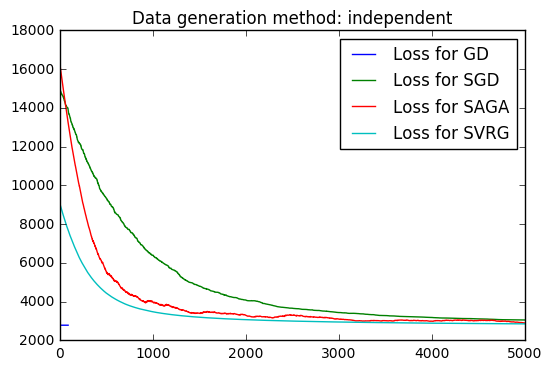

In [103]:
curr_steps = [steps_ind[GD], steps_ind[SGD], steps_ind[SAGA], steps_ind[SVRG]]
perform_simulation(n,d, 10**(-7), INDEPENDENT, curr_steps, [], is_prox=False)

The data dimensions are n = 10000 and d = 10 and precision = 1e-07
---------------------------------------------------------------
Gradient descent took 1.11059093475 seconds and performed 736 steps
Number of nonzero coeff: 10
Squared error for betas: 0.0578382681832
Steps count for GD: 736
The loss was 3604.76924467
---------------------------------------------------------------
Stochastic gradient descent took 4.12168598175 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 6.20093255643
Steps count for SGD: 5000
The loss was 4356.1471587
---------------------------------------------------------------
SAGA took 3.92435097694 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 1.33006194754
Steps count for SAGA: 5000
The loss was 3681.87056683
---------------------------------------------------------------
SVRG took 1.18155217171 seconds and performed 1400 steps
Number of nonzero coeff: 10
Squared error for betas: 10

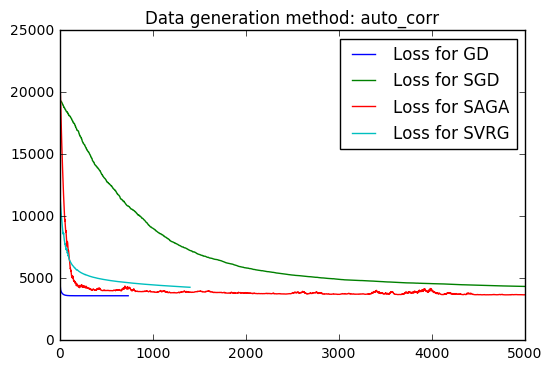

In [107]:
curr_steps = [steps_auto[GD], steps_auto[SGD], steps_auto[SAGA], steps_auto[SVRG]]
perform_simulation(n,d, 10**(-7), AUTO_CORR, curr_steps, [], is_prox=False)

The data dimensions are n = 10000 and d = 10 and precision = 1e-09
---------------------------------------------------------------
Gradient descent took 4.34133887291 seconds and performed 2626 steps
Number of nonzero coeff: 10
Squared error for betas: 0.104487529199
Steps count for GD: 2626
The loss was 2413.81180757
---------------------------------------------------------------
Stochastic gradient descent took 4.116065979 seconds and performed 4537 steps
Number of nonzero coeff: 10
Squared error for betas: 3.09123680701
Steps count for SGD: 4537
The loss was 2531.27376993
---------------------------------------------------------------
SAGA took 3.84077501297 seconds and performed 5000 steps
Number of nonzero coeff: 10
Squared error for betas: 7.98480616889
Steps count for SAGA: 5000
The loss was 2744.65155614
---------------------------------------------------------------
SVRG took 3.3331580162 seconds and performed 4300 steps
Number of nonzero coeff: 10
Squared error for betas: 7.0

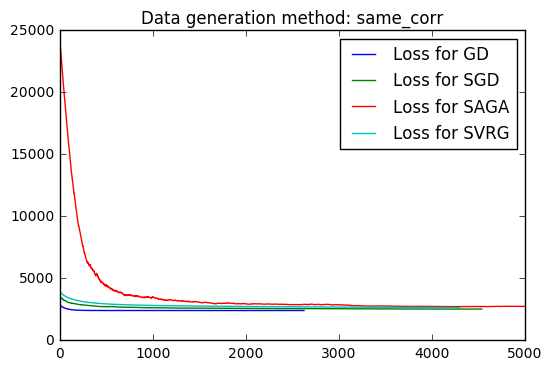

In [101]:
curr_steps = [steps_same[GD], steps_same[SGD], steps_same[SAGA], steps_same[SVRG]]
perform_simulation(n,d, 10**(-7), SAME_CORR, curr_steps, [], is_prox=False)

We also check how the data size affects our results. Here we test for $n=1000$ and $d=5$

In [109]:
dictionary_nonzero = {}
n = 10**3
d = 5
STEPS = 5*10**3
for method in [INDEPENDENT, SAME_CORR, AUTO_CORR]:
    for f in [GD, SGD, SAGA, SVRG]:
        step, lam = find_best_parameters(n, d, method, f, 10**np.linspace(-5,-2,10), [], False, plot_losses=False)
        dictionary_nonzero[(f,method)]=(step,lam)
        print('Best parameters for {} in settings {} is gamma={}'.format(f,method,step))

steps_ind = {x[0][0]:x[1][0] for x in dictionary_nonzero.items() if x[0][1]==INDEPENDENT}
steps_auto = {x[0][0]:x[1][0] for x in dictionary_nonzero.items() if x[0][1]==AUTO_CORR}
steps_same = {x[0][0]:x[1][0] for x in dictionary_nonzero.items() if x[0][1]==SAME_CORR}
print(steps_ind)
print(steps_auto)
print(steps_same)

Best parameters for gd in settings independent is gamma=0.01
Best parameters for sgd in settings independent is gamma=0.01
Best parameters for saga in settings independent is gamma=0.01
Best parameters for svrg in settings independent is gamma=0.00464158883361
Best parameters for gd in settings same_corr is gamma=0.01
Best parameters for sgd in settings same_corr is gamma=0.01
Best parameters for saga in settings same_corr is gamma=0.01
Best parameters for svrg in settings same_corr is gamma=0.01
Best parameters for gd in settings auto_corr is gamma=0.01
Best parameters for sgd in settings auto_corr is gamma=0.00464158883361
Best parameters for saga in settings auto_corr is gamma=0.01
Best parameters for svrg in settings auto_corr is gamma=0.01
{'saga': 0.01, 'gd': 0.01, 'sgd': 0.01, 'svrg': 0.0046415888336127772}
{'saga': 0.01, 'gd': 0.01, 'sgd': 0.0046415888336127772, 'svrg': 0.01}
{'saga': 0.01, 'gd': 0.01, 'sgd': 0.01, 'svrg': 0.01}


In [110]:
n=10**3
d=5

The data dimensions are n = 1000 and d = 5 and precision = 1e-05
---------------------------------------------------------------
Gradient descent took 0.00625896453857 seconds and performed 33 steps
Number of nonzero coeff: 5
Squared error for betas: 0.0108569985094
Steps count for GD: 33
The loss was 342.821819213
---------------------------------------------------------------
Stochastic gradient descent took 0.340475082397 seconds and performed 2597 steps
Number of nonzero coeff: 5
Squared error for betas: 0.55221425545
Steps count for SGD: 2597
The loss was 352.53986806
---------------------------------------------------------------
SAGA took 0.782948970795 seconds and performed 5000 steps
Number of nonzero coeff: 5
Squared error for betas: 0.0905678050184
Steps count for SAGA: 5000
The loss was 344.116821635
---------------------------------------------------------------
SVRG took 0.787962913513 seconds and performed 5000 steps
Number of nonzero coeff: 5
Squared error for betas: 0.

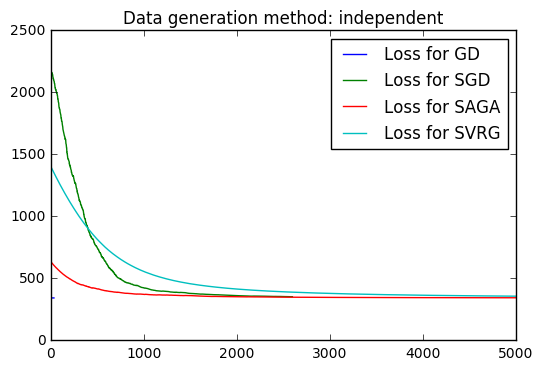

In [111]:
curr_steps = [steps_ind[GD], steps_ind[SGD], steps_ind[SAGA], steps_ind[SVRG]]
perform_simulation(n,d, 10**(-5), INDEPENDENT, curr_steps, [], is_prox=False)

The data dimensions are n = 1000 and d = 5 and precision = 1e-05
---------------------------------------------------------------
Gradient descent took 0.0270109176636 seconds and performed 107 steps
Number of nonzero coeff: 5
Squared error for betas: 0.382868352639
Steps count for GD: 107
The loss was 330.029944539
---------------------------------------------------------------
Stochastic gradient descent took 0.153546094894 seconds and performed 1103 steps
Number of nonzero coeff: 5
Squared error for betas: 6.81792131239
Steps count for SGD: 1103
The loss was 373.57639466
---------------------------------------------------------------
SAGA took 0.812139034271 seconds and performed 5000 steps
Number of nonzero coeff: 5
Squared error for betas: 0.457457014942
Steps count for SAGA: 5000
The loss was 332.818258081
---------------------------------------------------------------
SVRG took 0.73671913147 seconds and performed 4600 steps
Number of nonzero coeff: 5
Squared error for betas: 1.28

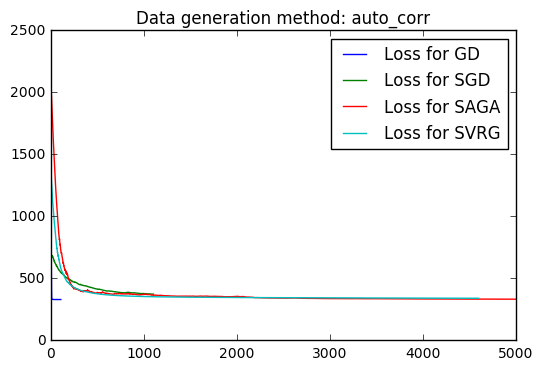

In [112]:
curr_steps = [steps_auto[GD], steps_auto[SGD], steps_auto[SAGA], steps_auto[SVRG]]
perform_simulation(n,d, 10**(-5), AUTO_CORR, curr_steps, [], is_prox=False)

The data dimensions are n = 1000 and d = 5 and precision = 1e-05
---------------------------------------------------------------
Gradient descent took 0.0293700695038 seconds and performed 106 steps
Number of nonzero coeff: 5
Squared error for betas: 0.0487590861773
Steps count for GD: 106
The loss was 255.408826125
---------------------------------------------------------------
Stochastic gradient descent took 0.0932462215424 seconds and performed 766 steps
Number of nonzero coeff: 5
Squared error for betas: 4.25583854802
Steps count for SGD: 766
The loss was 303.902097444
---------------------------------------------------------------
SAGA took 0.839253902435 seconds and performed 5000 steps
Number of nonzero coeff: 5
Squared error for betas: 1.28867039678
Steps count for SAGA: 5000
The loss was 262.515317954
---------------------------------------------------------------
SVRG took 0.709354877472 seconds and performed 5000 steps
Number of nonzero coeff: 5
Squared error for betas: 1.4

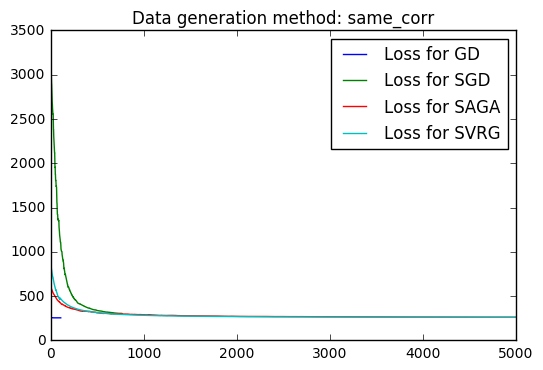

In [113]:
curr_steps = [steps_same[GD], steps_same[SGD], steps_same[SAGA], steps_same[SVRG]]
perform_simulation(n,d, 10**(-5), SAME_CORR, curr_steps, [], is_prox=False)

Measuring execution time for our functions

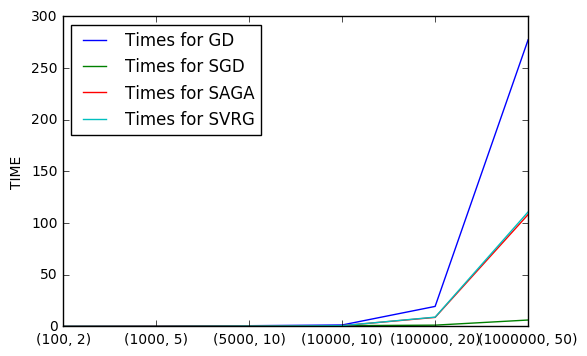

In [125]:
ns = [100, 1000, 5000, 10**4, 10**5, 10**6]
ds = [2,5,10,10,20,50]
times = np.empty((4, len(ns)))
STEPS = 10**3

for i,s in enumerate(zip(ns,ds)):
    d = s[1]
    n = s[0]
    x,y,beta = generate_all(n,d,0.8, AUTO_CORR)
    t1 = time()
    a, losses, steps_count = gradient_descent(x, y, epsilon=10**(-7), step=0.00001, lam=0, prox=False)
    times[0,i] = time()-t1
    t1 = time()
    a, losses, steps_count = gradient_descent(x, y, epsilon=10**(-7), step=0.00001, lam=0, prox=False, stochastic=True)
    times[1,i] = time()-t1
    t1 = time()
    a, losses, steps_count = saga(x, y, epsilon=10**(-7), step=0.00001, lam=0, prox=False)
    times[2,i] = time()-t1
    t1 = time()
    a, losses, steps_count = svrg(x, y, epsilon=10**(-7), step=0.00001, lam=0, prox=False)
    times[3,i] = time()-t1
    
plt.figure(1)
plt.plot(np.arange(len(ns)), times[0,:], label='Times for GD')
plt.plot(np.arange(len(ns)), times[1,:], label='Times for SGD')
plt.plot(np.arange(len(ns)), times[2,:], label='Times for SAGA')
plt.plot(np.arange(len(ns)), times[3,:], label='Times for SVRG')
xticks(np.arange(len(ns)),zip(ns,ds))
ylabel('TIME')
plt.legend(loc=2)
plt.show()    

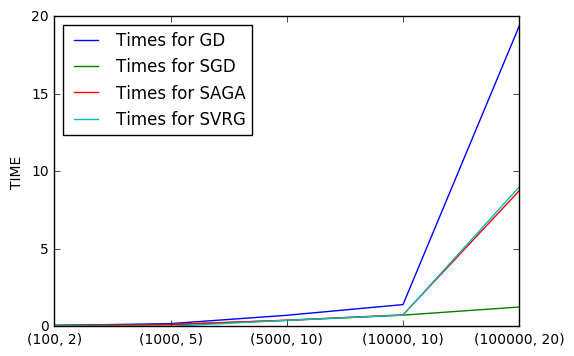

In [129]:
plt.figure(1)
plt.plot(np.arange(len(ns)-1), times[0,:5], label='Times for GD')
plt.plot(np.arange(len(ns)-1), times[1,:5], label='Times for SGD')
plt.plot(np.arange(len(ns)-1), times[2,:5], label='Times for SAGA')
plt.plot(np.arange(len(ns)-1), times[3,:5], label='Times for SVRG')
xticks(np.arange(len(ns)-1),zip(ns[:5],ds[:5]))
ylabel('TIME')
plt.legend(loc=2)
plt.show()    

Finding best parameters with sparse $\beta$ vector

In [21]:
dictionary_zero = {}
n = 10**4
d = 10
STEPS = 3*10**3
for method in [INDEPENDENT]:
    for f in [GD, SGD, SAGA, SVRG]:
        step, lam = find_best_parameters(n, d, method, f, 10**np.linspace(-6,-2,5), 10**np.linspace(-4,1,5), is_prox=True, plot_losses=False)
        dictionary_zero[(f,method)]=(step,lam)
        print('Best parameters for {} in settings {} is gamma={} and lambda={}'.format(f,method,step,lam))

steps_ind = {x[0][0]:x[1][0] for x in dictionary_zero.items() if x[0][1]==INDEPENDENT}
lam_ind = {x[0][0]:x[1][1] for x in dictionary_zero.items() if x[0][1]==INDEPENDENT}

Best parameters for gd in settings independent is gamma=0.0001 and lambda=0.0001
Best parameters for sgd in settings independent is gamma=0.01 and lambda=0.0316227766017
Best parameters for saga in settings independent is gamma=0.01 and lambda=0.00177827941004
Best parameters for svrg in settings independent is gamma=0.01 and lambda=0.00177827941004


In [22]:
curr_steps = [steps_ind[GD], steps_ind[SGD], steps_ind[SAGA], steps_ind[SVRG]]
curr_lambdas = [lam_ind[GD], lam_ind[SGD], lam_ind[SAGA], lam_ind[SVRG]]

This time we will use a fixed data set because we want to measure the effect in different lambdas on the effectiveness of the methods

In [23]:
x,y,beta = generate_all(n,d, 0.8, INDEPENDENT, is_prox=True)

Gradient descent took 0.450102090836 seconds and performed 299 steps
Number of nonzero coeff: 10
Squared error for betas: 0.00828814238824
Steps count for GD: 299
The loss was 4712.07556043
---------------------------------------------------------------
Stochastic gradient descent took 2.2671790123 seconds and performed 3000 steps
Number of nonzero coeff: 10
Squared error for betas: 0.238137722388
Steps count for SGD: 3000
The loss was 4831.41323767
---------------------------------------------------------------
SAGA took 2.28641796112 seconds and performed 3000 steps
Number of nonzero coeff: 10
Squared error for betas: 0.0580990984056
Steps count for SAGA: 3000
The loss was 4756.46912929
---------------------------------------------------------------
SVRG took 2.28079485893 seconds and performed 3000 steps
Number of nonzero coeff: 10
Squared error for betas: 0.0191045340375
Steps count for SVRG: 3000
The loss was 4721.11164864


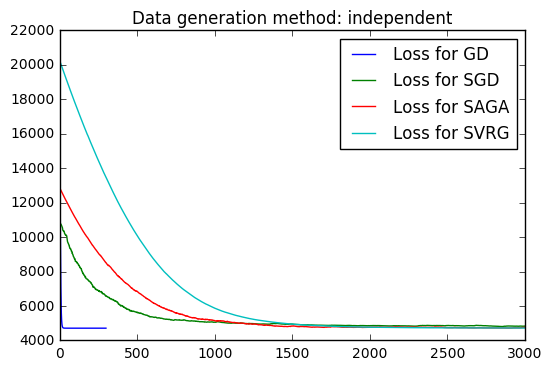

In [24]:
perform_simulation_with_data(10**(-11), INDEPENDENT, curr_steps, curr_lambdas, x, y, beta, is_prox=True)

We see that the vectors $\beta$ found were not sparse as the original one. So in order to get better results with respect to finding solution with similar sparsity we have to stop looking at score but more on number of nonzero coefficients

Gradient descent took 0.492583036423 seconds and performed 295 steps
Number of nonzero coeff: 2
Original beta: [ 0.      0.      0.      0.      0.      1.8054  0.5144  0.      0.      0.    ]
 Found beta: [-0.     -0.     -0.     -0.     -0.      1.6427  0.4216  0.     -0.     -0.    ]
Squared error for betas: 0.0350926201053
Steps count for GD: 295
The loss was 4736.77439718
---------------------------------------------------------------
Stochastic gradient descent took 2.33724403381 seconds and performed 3000 steps
Number of nonzero coeff: 6
Original beta: [ 0.      0.      0.      0.      0.      1.8054  0.5144  0.      0.      0.    ]
 Found beta: [ -0.0000e+00  -2.5619e-03  -0.0000e+00   1.0369e-03  -1.4116e-05
   4.9590e-03  -0.0000e+00   1.8241e-03  -4.4838e-03   0.0000e+00]
Squared error for betas: 3.50633548269
Steps count for SGD: 3000
The loss was 6930.55751702
---------------------------------------------------------------
SAGA took 2.19471812248 seconds and performed 3000

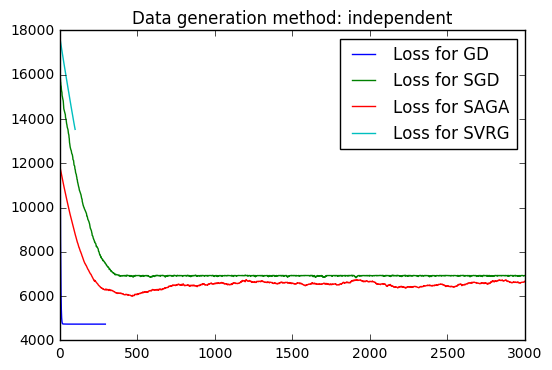

In [35]:
perform_simulation_with_data(10**(-13), INDEPENDENT, curr_steps, [130.0, 0.45, 0.25 ,0.13], x, y, beta, is_prox=True, show_beta=True)